# Model Selection
 This notebook shows how to implement model selection using ELFI for the models defined in the following paper: "Semi-automatic selection of summary statistics for ABC model choice" by Prangle et al, 2013. https://arxiv.org/abs/1302.5624

**NOTE:** It's required to have *ELFI* of version >= 0.7.1

In [1]:
import numpy as np
import elfi
import scipy.stats as ss
import matplotlib.pyplot as plt

from elfi.methods.model_selection import compare_models

In [2]:
# Helper method for comparing different models
# Compare different models by using rejection sampling
def compare_rejection(distances, n_samples=100, threshold=1e5, batch_size=1):
    samples = []
    for dist in distances:
        rej = elfi.Rejection(dist, batch_size=batch_size)
        samples.append(rej.sample(n_samples, threshold=threshold))
    
    return compare_models(samples)

## Case 1. 3 models:
### A1: Poisson($\theta$), where $\theta \sim Exp(1)$ .
### A2: Geometric($\theta$), where $\theta \sim Uniform(0, 1)$.
### A3: Binomial(10, $\theta$), where $\theta \sim Beta(1, 9)$.

As a summary statistics use $S_{10}(x) = \{x^{(5)}, x^{(15)}, \ldots, x^{(95)}\}$.

In [3]:
elfi.new_model(name='Model 1')

# Define priors for A1, A2, A3 respectively
a1_theta = elfi.Prior('expon', 1, name='a1_theta')
a2_theta = elfi.Prior('uniform', 0, 1, name='a2_theta')
a3_theta = elfi.Prior('beta', 1, 9, name='a3_theta')

# Define models A1, A2, A3 respectively
def a1_model(theta, N=100, batch_size=1, random_state=None):
    return ss.poisson.rvs(theta, size=(batch_size, N), random_state=random_state)

def a2_model(theta, N=100, batch_size=1, random_state=None):
    return ss.geom.rvs(theta, size=(batch_size, N), random_state=random_state)

def a3_model(theta, N=100, batch_size=1, random_state=None):
    return ss.binom.rvs(10, theta, size=(batch_size, N), random_state=random_state)

In [4]:
# Define summary statistics for all the models A1, A2, A3.
def a_summary(data):
    percentiles = np.linspace(5, 95, num=10)
    return np.percentile(data, percentiles, axis=1).T

In [5]:
# Let's generate observed data a_y0 from model A1. 
# You can change it to any value you want and generate it from any model. 
a_y0 = a1_model(1)

In [6]:
# Define simulators for each model.
a1_sim = elfi.Simulator(a1_model, a1_theta, observed=a_y0, name='a1_sim')
a2_sim = elfi.Simulator(a2_model, a2_theta, observed=a_y0, name='a2_sim')
a3_sim = elfi.Simulator(a3_model, a3_theta, observed=a_y0, name='a3_sim')

In [7]:
# Define summary statistics for each model.
a1_summary = elfi.Summary(a_summary, a1_sim, name='a1_summary')
a2_summary = elfi.Summary(a_summary, a2_sim, name='a2_summary')
a3_summary = elfi.Summary(a_summary, a3_sim, name='a3_summary')

In [8]:
# Define euclidean distances for each model.
a1_dist = elfi.Distance('euclidean', a1_summary, name='a1_dist')
a2_dist = elfi.Distance('euclidean', a2_summary, name='a2_dist')
a3_dist = elfi.Distance('euclidean', a3_summary, name='a3_dist')

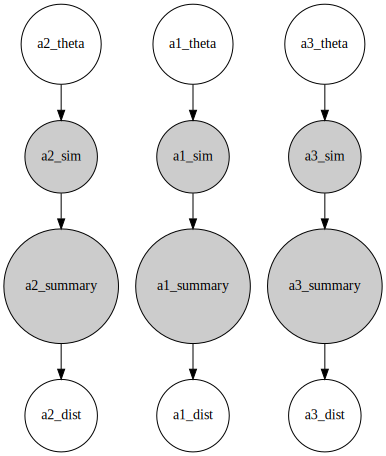

In [9]:
# Draw graphs for models to make sure everything is correctly connected.
elfi.draw(a1_dist)

In [10]:
N_EXP = 30
# Perform experiment N_EXP times and plot the results
p1_probs = []
p2_probs = []
p3_probs = []
for n in range(N_EXP):
    p1, p2, p3 = compare_rejection([a1_dist, a2_dist, a3_dist])
    p1_probs.append(p1)
    p2_probs.append(p2)
    p3_probs.append(p3)

{'boxes': [<matplotlib.lines.Line2D at 0x7fa89916c390>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa899180438>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa8991860f0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa899180c88>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa89916cb38>,
  <matplotlib.lines.Line2D at 0x7fa899191b38>]}

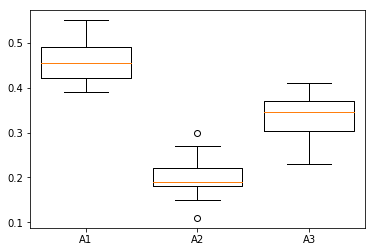

In [11]:
plt.boxplot((p1_probs, p2_probs, p3_probs), labels=['A1', 'A2', 'A3'], widths=0.8)

As we can see model $A_1$ is a bit more probable than model $A_3$, but much less improbable than $A_2$, when we're using Rejection Sampling.

## Case 2. 2 models:
### B1: Laplace($\theta$, $\frac{1}{\sqrt{2}}$), where $\theta \sim Normal(0, 2^2)$ .
### B2: Normal($\theta$, $1$), where $\theta \sim Normal(0, 2^2)$.

As a summary statistics use $S_{10}(x) = \{x^{(5)}, x^{(15)}, \ldots, x^{(95)}\}$.

In [12]:
elfi.new_model(name='Model 2')

# Define priors for B1 and B2 respectively
b1_theta = elfi.Prior('norm', 0, 2, name='b1_theta')
b2_theta = elfi.Prior('norm', 0, 2, name='b2_theta')

# Define models A1, A2, A3 respectively
def b1_model(theta, N=100, batch_size=1, random_state=None):
    return ss.laplace.rvs(theta, 1.0/np.sqrt(2), size=(batch_size, N), random_state=random_state)

def b2_model(theta, N=100, batch_size=1, random_state=None):
    return ss.norm.rvs(theta, 1, size=(batch_size, N), random_state=random_state)

In [13]:
# Define summary statistics for each model
def b_summary(data):
    percentiles = np.linspace(5, 95, num=10)
    return np.percentile(data, percentiles, axis=1).T

In [14]:
# Let's generate observed data y0 from model B1. 
# You can change it to any value you want and generate it from any model. 
b_y0 = b1_model(0)

In [15]:
# Define simulators for each model.
b1_sim = elfi.Simulator(b1_model, b1_theta, observed=b_y0, name='b1_sim')
b2_sim = elfi.Simulator(b2_model, b2_theta, observed=b_y0, name='b2_sim')

In [16]:
# Define summary statistics for each model.
b1_summary = elfi.Summary(b_summary, b1_sim, name='b1_summary')
b2_summary = elfi.Summary(b_summary, b2_sim, name='b2_summary')

In [17]:
# Define euclidean distances for each model.
b1_dist = elfi.Distance('euclidean', b1_summary, name='b1_dist')
b2_dist = elfi.Distance('euclidean', b2_summary, name='b2_dist')

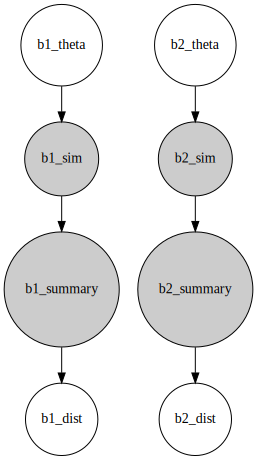

In [18]:
# Draw graphs for models to make sure everything is correctly connected.
elfi.draw(b1_dist)

In [19]:
# Perform experiment N_EXP times and plot the results
p1_probs = []
p2_probs = []
for n in range(N_EXP):
    p1, p2 = compare_rejection([b1_dist, b2_dist])
    p1_probs.append(p1)
    p2_probs.append(p2)

{'boxes': [<matplotlib.lines.Line2D at 0x7fa8991a0c18>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa8991a8550>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa8991a6208>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa8991a8da0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa8991a0da0>,
  <matplotlib.lines.Line2D at 0x7fa8991a6e80>]}

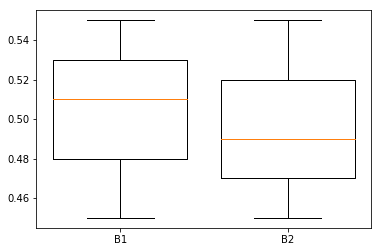

In [20]:
plt.boxplot((p1_probs, p2_probs), labels=['B1', 'B2'], widths=0.8)

As we can see model $B_1$ is a bit more probable than model $B_2$, when we're using Rejection Sampling.